# Data Loading

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('/workspace/Kaggle_Days/CV/cv_comp/train.csv')
test = pd.read_csv('/workspace/Kaggle_Days/CV/cv_comp/test.csv')

def get_train_file_path(image_id):
    return "/workspace/Kaggle_Days/CV/cv_comp/train_images/{}".format(image_id)

def get_test_file_path(image_id):
    return "/workspace/Kaggle_Days/CV/cv_comp/test_images/{}".format(image_id)

train['file_path'] = train['image_id'].apply(get_train_file_path)
test['file_path'] = test['image_id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,image_id,brightness,contrast,colorfulness,sharpness,MOS,file_path
0,00036b9ea9.jpg,0.507058,0.302144,0.170448,21.493220,3.653465,/workspace/Kaggle_Days/CV/cv_comp/train_images...
1,001c4e9be6.jpg,0.618813,0.371019,0.011844,23.570068,3.244275,/workspace/Kaggle_Days/CV/cv_comp/train_images...
2,001c982074.jpg,0.336466,0.243211,0.275342,9.632381,2.843137,/workspace/Kaggle_Days/CV/cv_comp/train_images...
3,001dd41def.jpg,0.371659,0.252384,0.425490,6.649980,2.336364,/workspace/Kaggle_Days/CV/cv_comp/train_images...
4,0024a6e559.jpg,0.545263,0.333793,0.195252,7.552733,2.363636,/workspace/Kaggle_Days/CV/cv_comp/train_images...


,image_id,brightness,contrast,colorfulness,sharpness,file_path
0,00439614c2.jpg,0.387638,0.379885,0.131153,11.679899,/workspace/Kaggle_Days/CV/cv_comp/test_images/...
1,0075aff7fa.jpg,0.665401,0.242671,0.246394,16.625090,/workspace/Kaggle_Days/CV/cv_comp/test_images/...
2,009ed311ee.jpg,0.416759,0.347511,0.165954,18.508671,/workspace/Kaggle_Days/CV/cv_comp/test_images/...
3,00c942fbe7.jpg,0.354192,0.280639,0.219046,21.409334,/workspace/Kaggle_Days/CV/cv_comp/test_images/...
4,011ef38420.jpg,0.458954,0.159165,0.305201,21.264408,/workspace/Kaggle_Days/CV/cv_comp/test_images/...


In [3]:
from PIL import Image
np.array(Image.open(train['file_path'].iloc[0])).shape

(384, 512, 3)

# Quick EDA

<AxesSubplot:>

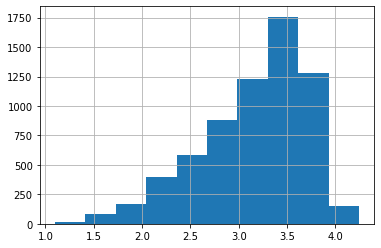

In [4]:
train['MOS'].hist()

In [5]:
# plt.figure(figsize=(20, 20))
# row, col = 5, 5
# for i in range(row * col):
#     plt.subplot(col, row, i+1)
#     image = cv2.imread(train.loc[i, 'file_path'])
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     target = train.loc[i, 'Pawpularity']
#     plt.imshow(image)
#     plt.title(f"target: {target}")
# plt.show()

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = '/workspace/data/kaggle_weights/'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [17]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=10
    num_workers=4
    size=256
    model_name='tf_efficientnet_b3_ns'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=8
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=20 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-3
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='MOS'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    grad_cam=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

In [9]:
# ====================================================
# wandb
# ====================================================
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb_api = user_secrets.get_secret("wandb_api")

# import wandb
# wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))


# Utils

In [18]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [19]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)

Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', "bins"]).size())

fold  bins
0     0         3
      1         7
      2        18
      3        31
      4        60
             ... 
4     8       198
      9       253
      10      274
      11      118
      12       12
Length: 65, dtype: int64

# Dataset

In [21]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

    
# class GradCAMDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.image_ids = df['Id'].values
#         self.file_names = df['file_path'].values
#         self.labels = df[CFG.target_col].values
#         self.transform = get_transforms(data='valid')
        
#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         image_id = self.image_ids[idx]
#         file_path = self.file_names[idx]
#         image = cv2.imread(file_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         vis_image = cv2.resize(image, (CFG.size, CFG.size)).copy()
#         if self.transform:
#             image = self.transform(image=image)['image']
#         label = torch.tensor(self.labels[idx]).float()
#         return image_id, image, vis_image, label

# Transforms

In [22]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        
        return A.Compose([
            A.SmallestMaxSize(max_size=384, p=1.0),
            A.RandomCrop(height=384, width=384, p=1.0),
            A.HorizontalFlip(p = 0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.SmallestMaxSize(max_size=384, p=1.0),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

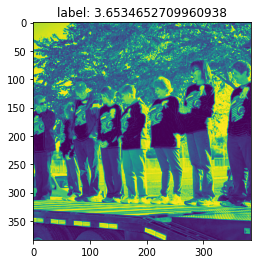

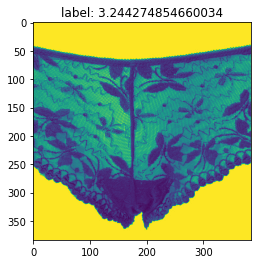

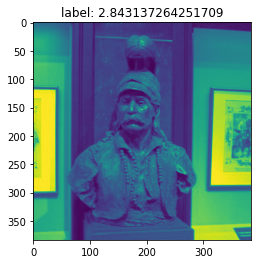

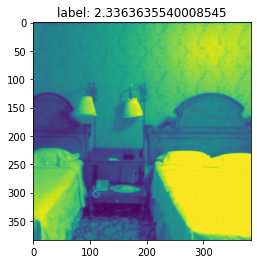

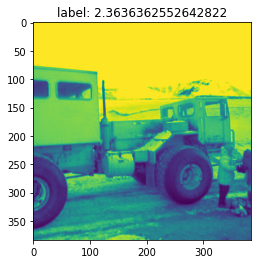

In [23]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(4, 4))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

# MODEL

In [24]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

# Loss

In [25]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Helper functions

In [26]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    tk1 = tqdm(enumerate(train_loader),total=len(train_loader))
    for step, (images, labels) in tk1:
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        end = time.time()
        tk1.set_postfix({'train_loss':losses.avg})
        
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    losses = AverageMeter()
    preds = []
    start = end = time.time()
    tk2 = tqdm(enumerate(valid_loader),total=len(valid_loader))
    for step, (images, labels) in tk2:
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        end = time.time()
        tk2.set_postfix({'valid_loss':losses.avg})
        
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [27]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = RMSELoss()

    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [28]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """
    print('yes')
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [29]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
========== fold: 0 training ==========


yes


100%|██████████| 21/21 [00:04<00:00,  5.07it/s, valid_loss=0.294]
Epoch 1 - avg_train_loss: 0.4291  avg_val_loss: 0.2938  time: 61s
Epoch 1 - avg_train_loss: 0.4291  avg_val_loss: 0.2938  time: 61s
Epoch 1 - Score: 0.2951
Epoch 1 - Score: 0.2951
Epoch 1 - Save Best Score: 0.2951 Model
Epoch 1 - Save Best Score: 0.2951 Model
100%|██████████| 21/21 [00:03<00:00,  6.65it/s, valid_loss=0.316]
Epoch 2 - avg_train_loss: 0.2588  avg_val_loss: 0.3160  time: 55s
Epoch 2 - avg_train_loss: 0.2588  avg_val_loss: 0.3160  time: 55s
Epoch 2 - Score: 0.3172
Epoch 2 - Score: 0.3172
100%|██████████| 21/21 [00:03<00:00,  6.66it/s, valid_loss=0.251]
Epoch 3 - avg_train_loss: 0.2463  avg_val_loss: 0.2513  time: 56s
Epoch 3 - avg_train_loss: 0.2463  avg_val_loss: 0.2513  time: 56s
Epoch 3 - Score: 0.2526
Epoch 3 - Score: 0.2526
Epoch 3 - Save Best Score: 0.2526 Model
Epoch 3 - Save Best Score: 0.2526 Model
100%|██████████| 21/21 [00:03<00:00,  6.54it/s, valid_loss=0.223]
Epoch 4 - avg_train_loss: 0.2243  av